Found 2152 files belonging to 3 classes.
['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,281,539 (16.33 MB)

 Trainable params: 1,052,675 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.6221 - loss: 0.8743 - val_accuracy: 0.9190 - val_loss: 0.2265
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.9201 - loss: 0.2319 - val_accuracy: 0.9333 - val_loss: 0.1660
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.9415 - loss: 0.1744 - val_accuracy: 0.9571 - val_loss: 0.1277
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.9602 - loss: 0.1288 - val_accuracy: 0.9524 - val_loss: 0.1100
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.9682 - loss: 0.1139 - val_accuracy: 0.9524 - val_loss: 0.0957
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.9651 - loss: 0.0953 - val_accuracy: 0.9524 - val_loss: 0.1096
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.9680 - loss: 0.1016 - val_accuracy: 0.9667 - val_loss: 0.0727
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.9812 - loss: 0.0659 - val_accu

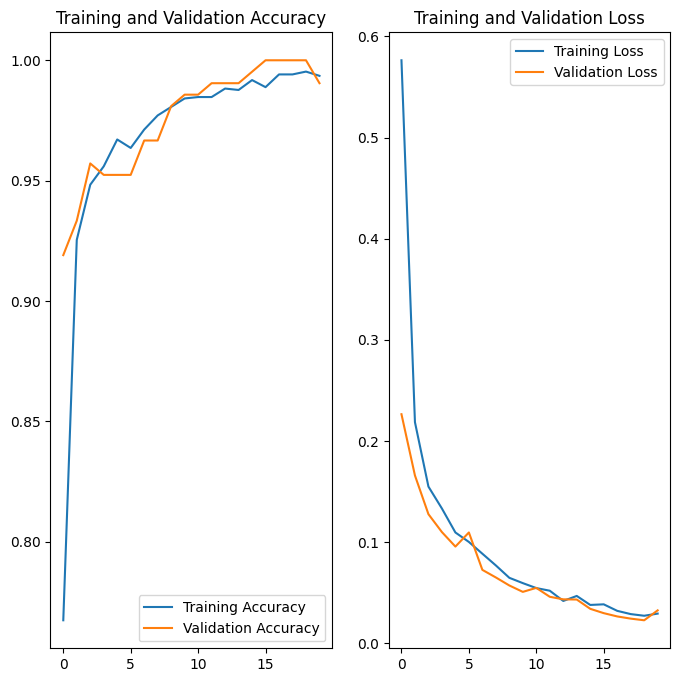

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 30

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=5)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


IMG_SIZE = 224
CHANNELS = 3
n_classes = 3

resize = layers.Resizing(IMG_SIZE,IMG_SIZE)
rescale = layers.Rescaling(1.0/255)
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1,0.1)
])
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

learning_rate = 0.0001  
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    verbose=1
)

score = model.evaluate(test_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
